# **3. Predict**
## Using the trained model, now make predictions of call category on unobserved recordings.

In [5]:
import os
import numpy as np
import pandas as pd
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from glob import glob
import soundfile as sf

### Load in the trained model...

In [9]:
model = tf.keras.models.load_model(os.path.join(os.getcwd(),'2D_CNN_model_with_noise.h5'))

### Define helper functions to convert out-of-sample recordings to mel-spectrograms, and save as images

In [11]:
# Function to create log mel spectrogram and return it as NumPy array
def create_spectrogram(chunk_audio, sr):
    ms = librosa.feature.melspectrogram(y=chunk_audio, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    return log_ms  

# Function to preprocess log mel spectrogram data and return as model input
def create_chunk_image_data(log_ms, sr, chunk_num):
    plt.figure(figsize=(2.24, 2.24), dpi=100)  
    librosa.display.specshow(log_ms, sr=sr)
    plt.axis('off')  
    
    # Save the figure temporarily
    img_file = f'temp_spec_{chunk_num}.png'
    plt.savefig(img_file, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Load and preprocess the image for model input
    x = image.load_img(img_file, target_size=(224, 224))
    x = image.img_to_array(x)
    x = x / 255.0  # Normalize pixel values
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    
    # Remove the temporary image file
    os.remove(img_file)
    
    return x
    
# Predict on each chunk/window
def predict_chunk(x):
    
    #predicting class of call using features extracted
    pred = model.predict(x, verbose=0)
    
    return pred

### Define a window that uses a sliding-window approach to make call predictions on 1 second windows of unobserved recordings.

In [12]:
# Function to process WAV file with sliding window and overlap
def process_wav_with_overlap(wav_file, chunk_size=1.0, overlap=0):
    
    # Extract the recording's unique id 
    wav_id = (wav_file.split('/')[-1]).split('.')[0]
    print(f'Recording ID: {wav_id} \n') 
    
    # Load in wav file
    y, sr = librosa.load(wav_file, sr=44100)
    print(f'Recording properties: len(y) = {len(y)}, sr (Hz) = {sr}, duration (s) = {len(y)/sr} \n')

    # Calculate parameters: chunk size and hop size
    chunk_size_samples = int(chunk_size * sr)  # Convert chunk size from seconds to # samples
    hop_size = int(chunk_size_samples * (1 - overlap))  # Hop size based on overlap percentage
    
    print(f'Chunking parameters: chunk size (# samples) = {chunk_size_samples}, hop size = {hop_size} \n')
    
    # Initialize prediction dictionary    
    class_predictions = {
        'laugh' : [], 
        'drum' : [], 
        'pik' : [], 
        'noise' : []
    }
    
    chunk_num = 0
    i = 0
    
    # Process the WAV file with sliding window and overlap
    while i + chunk_size_samples <= len(y): # Execute until we get to the end of the recording/before the last window is greater than the end.

        # Extract the current chunk 
        chunk = y[i:i + chunk_size_samples] 
        
        length = len(chunk)
        duration = length / sr
    
        # print(f"{chunk_file} has dur = {duration} s, length = {length}, sr = {sr}")
        
        # Create spectrogram for the chunk
        log_ms = create_spectrogram(chunk, sr)

        # Preprocess spectrogram data for model input
        x = create_chunk_image_data(log_ms, sr, chunk_num)

        # Make prediction for the chunk
        chunk_prediction = predict_chunk(x)
        #print(chunk_prediction, '\n')

        # Store or process the prediction as needed
        class_predictions['laugh'].append(chunk_prediction[0][0])  # Indexing based on call number set above
        class_predictions['drum'].append(chunk_prediction[0][1])
        class_predictions['pik'].append(chunk_prediction[0][2])
        class_predictions['noise'].append(chunk_prediction[0][3])
        
        chunk_num += 1 
        i += hop_size # increase i (window) by hop_size calculated above

    return class_predictions

### After gathering the prediction compositions for one recording, summarize the results by normalizing the prediction proportions for every class except the "noise" category. 

In [13]:
def prediction_composition(pred_iter):
    
    pred_comp = {}
    pred_comp_norm = {}
    
    for call in pred_iter:
        call_vals = pred_iter[call] # List of values per call type
        mean_val = np.mean(call_vals) # Calculate average probability for each call type in recording
        pred_comp[call] = mean_val # Set dictionary value equal to the calculated mean 
    
    tot = sum(pred_comp.values()) - pred_comp['noise']
    
    for i in pred_comp:
        if i != 'noise':
            pred_comp_norm[i] = pred_comp[i]/tot
    
    return pred_comp_norm

### Combine functions to be able to predict on many recordings at once.

In [14]:
# Predict on unobserved samples (default chunk size = 1s, with 0% overlap)
def predict_on_recordings(wav_file_list, chunk_size = 1, overlap = 0):
    
    # Initialize dictionary for df and lists for the dictionary
    prediction_df = {}
    u_ids = []
    prob_laugh = []
    prob_drum = []
    prob_pik = []

    for i, wav_file in enumerate(wav_file_list):
                
        # Extract the unique id for the recording
        unique_id = wav_file.split('/')[-1].split('.')[0]
        u_ids.append(unique_id)
        
        # Predict on the recording using specified chunk_size and overlap parameters
        pred_iter = process_wav_with_overlap(wav_file, chunk_size = chunk_size, overlap=overlap) # returns dictionary of prediction values
        
        # Optional: plot the prediction output
        plot_predictions(pred_iter)
        
        # Calculate the normalized probabilties (excluding the noise category)
        pred_comp = prediction_composition(pred_iter)
        print(pred_comp, '\n')
        prob_laugh.append(pred_comp.get('laugh'))
        prob_drum.append(pred_comp.get('drum'))
        prob_pik.append(pred_comp.get('pik'))
    
    prediction_df['unique_id'] = u_ids
    prediction_df['laugh'] = prob_laugh
    prediction_df['drum'] = prob_drum
    prediction_df['pik'] = prob_pik
    prediction_df['overlap'] = [overlap for x in u_ids]
    
    df = pd.DataFrame(prediction_df)

    return df

### Optional: Plot prediction probabilities as the window slides through the recording (which could be used as a visual confirmation of the model correctly or incorrectly classifying differnt portions of the recording being analyzed).

In [15]:
def plot_predictions(pred_dict, fig_size = (15,5)):
    
    # get range of samples (all classes should have the same) 
    x_values = range(len(pred_dict['laugh']))

    # plot
    plt.figure(figsize = fig_size)

    # set theme
    plt.style.use("fivethirtyeight")

    # plot each class
    plt.plot(x_values, pred_dict['laugh'], label='laugh', marker='o', linestyle='-')
    plt.plot(x_values, pred_dict['drum'], label='drum', marker='s', linestyle='-')
    plt.plot(x_values, pred_dict['pik'], label='pik', marker='^', linestyle='-')
    plt.plot(x_values, pred_dict['noise'], label='noise', marker='x', linestyle='-')
    
    plt.xlabel('Window/Index')
    plt.ylabel('Probability')
    plt.title('Probability Time Series for Each Class')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
all_wave_files = glob('/Users/calzada/birdsongs/wood/01_data/all_wav_files/*.wav')
all_wave_files
test = all_wave_files[100:101]
test

['/Users/calzada/birdsongs/wood/01_data/all_wav_files/90534411.wav']

Recording ID: 90534411 

Recording properties: len(y) = 139264, sr (Hz) = 44100, duration (s) = 3.1579138321995464 

Chunking parameters: chunk size (# samples) = 44100, hop size = 22050 



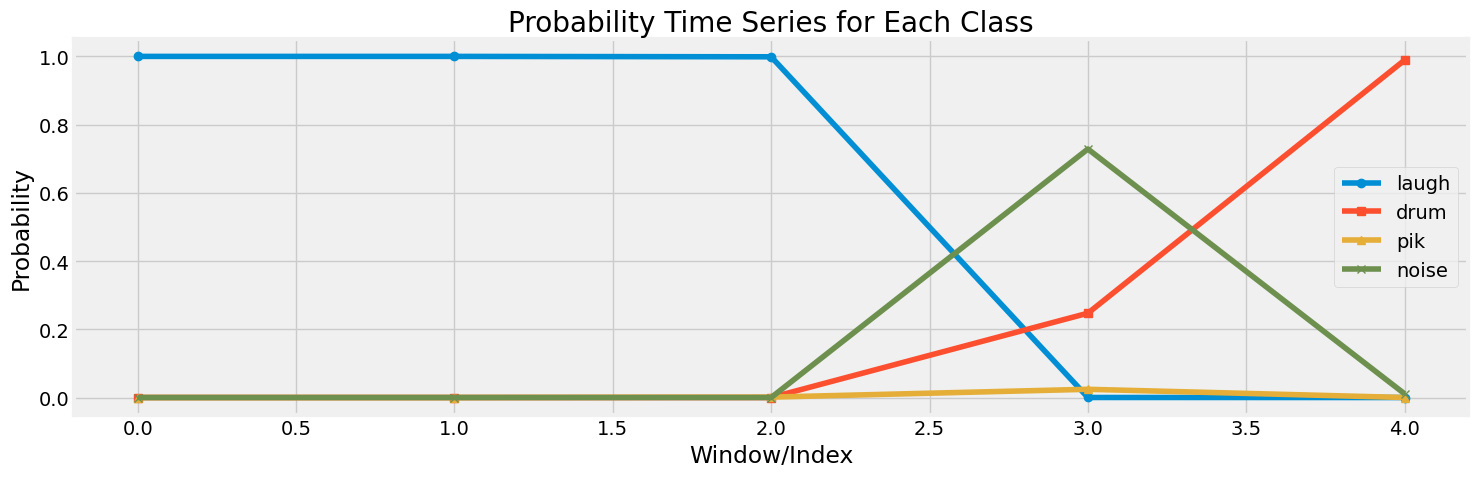

{'laugh': 0.7038520601599672, 'drum': 0.29019127076385287, 'pik': 0.005956669076180002} 



,unique_id,laugh,drum,pik,overlap
0,90534411,0.703852,0.290191,0.005957,0.5


In [23]:
predict_on_recordings(test, chunk_size=1, overlap=0.5)

### Predict on many recordings, and save resulting output.